In [150]:
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
import skimage

In [151]:
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

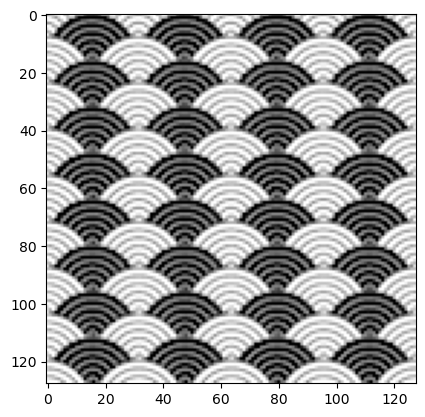

In [154]:
img = Image.open('circle.jpg').convert('L')
plt.imshow(img, cmap='gray')

In [155]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(128),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
img = transform(img)

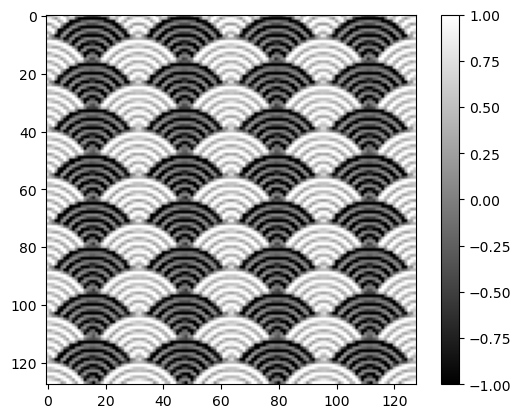

In [156]:
plt.imshow(img.reshape(128, 128), cmap='gray')
plt.colorbar()

In [157]:
class ImageFitting(torch.utils.data.Dataset):
    def __init__(self, img):
        super().__init__()
        self.pixels = img.view(-1, 1)
        self.coords = get_mgrid(128, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

In [158]:
kmm = np.sort(np.linspace(1, -1, 16, endpoint=False))
kx = np.zeros((128,))
ky = np.zeros((128,))
for i in range(8):
    for j in range(16):
        kx[i*16+j] = kmm[j]*np.cos(i * np.pi / 8)
        ky[i*16+j] = kmm[j]*np.sin(i * np.pi / 8)

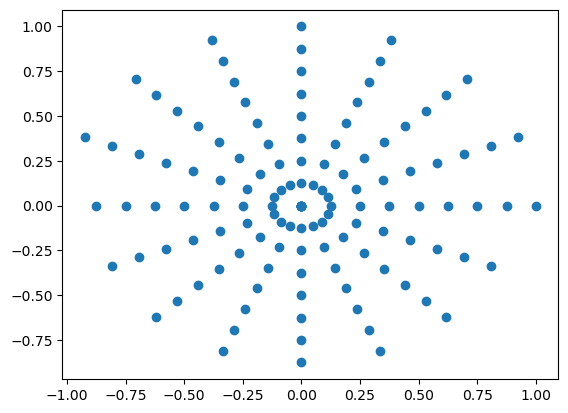

In [159]:
plt.scatter(kx, ky)

In [160]:
x = np.sort(np.linspace(1, -1, 128, endpoint=False))
y = np.linspace(1, -1, 128, endpoint=False)

In [161]:
H = np.zeros((128, 128**2), dtype=np.csingle)
for i in range(8):
    for j in range(16):
        for k in range(128):
            for l in range(128):
                H[i*16+j, k*128+l] = np.exp(-2*np.pi*1j*(kx[i*16+j]*x[l] + ky[i*16+j]*y[k]))

In [162]:
g = H.dot(img.reshape(-1, 1))

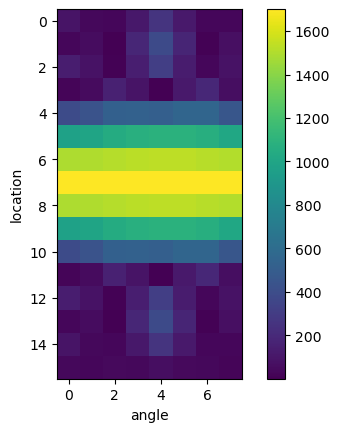

In [163]:
plt.imshow(np.abs(g).reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.colorbar()
plt.savefig('g_abs_circle.png', dpi=160)

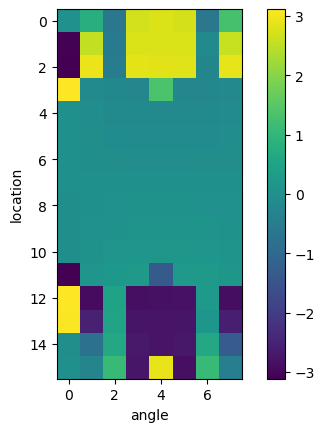

In [164]:
plt.imshow(np.angle(g).reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.colorbar()
plt.savefig('g_phase_circle.png', dpi=160)

In [165]:
cameraman = ImageFitting(img)
dataloader = torch.utils.data.DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

In [174]:
#from torchmetrics import MeanSquaredError, MeanAbsoluteError
class NeuralField(pl.LightningModule):
  def __init__(self, dataloader, H, g, n=64):
    super().__init__()
    self.dataloader = dataloader

    self.relu = torch.sin
    self.lin1 = nn.Linear(2, n)
    self.lin2 = nn.Linear(n, n)
    self.lin3 = nn.Linear(n, n)
    self.lin4 = nn.Linear(n, n)
    self.lin6 = nn.Linear(n, n)
    self.lin5 = nn.Linear(n, 1)
    self.out = nn.Tanh()
    #self.B = nn.Parameter(torch.randn(5, 2))
    self.H = nn.Parameter(H, requires_grad=False)
    self.g = nn.Parameter(g, requires_grad=False)
    #self.criterion = nn.MSELoss(reduction='sum')
  
  def forward(self, x):
    #x = torch.matmul(x, self.B.transpose(-1, -2))
    #x = torch.cat((torch.sin(2*np.pi*x), torch.cos(2*np.pi*x)), dim=-1)
    x = self.relu(self.lin1(x))
    x = self.relu(self.lin2(x))
    x = self.relu(self.lin3(x))
    x = self.relu(self.lin4(x))
    #x = self.relu(self.lin6(x))
    x = self.lin5(x)
    return self.out(x)
  
  def shared_step(self, batch):
    x, y = batch
    pred = self(x)
    pred = pred.reshape(-1, 1)
    gpred = torch.matmul(self.H, pred.type(torch.cfloat))
    loss = torch.mean(torch.pow((gpred - self.g).abs(), 2))
    #if self.current_epoch%50==0:
        #plt.imshow(pred.detach().numpy().reshape(256, 256), cmap='gray')
        #plt.savefig(F"images/illusion_fourier_sine/image_{self.current_epoch}.png", dpi=160)
    return loss
  
  def training_step(self, batch, batch_idx):
    loss = self.shared_step(batch)
    return {'loss':loss}
  
  def training_step_end(self, outputs):
    loss = outputs['loss'].mean()
    self.log('train_loss', loss, prog_bar=True, on_epoch=True)
    return {"loss": loss}

  def predict_step(self, batch, batch_idx: int , dataloader_idx: int = None):
        return self(batch[0])
  
  def train_dataloader(self):
    return self.dataloader
  
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
    sch = torch.optim.lr_scheduler.ConstantLR(optimizer, 0.99, 2000)
    return [optimizer]

In [176]:
Htensor = torch.tensor(H, dtype=torch.cfloat)
amptensor = torch.tensor(np.abs(g))
phasetensor = torch.tensor(np.angle(g))
gtensor = torch.tensor(g, dtype=torch.cfloat)
model = NeuralField(dataloader, Htensor, gtensor, 128)

trainer = pl.Trainer(
            max_epochs=2000,
            )
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type   | Params
--------------------------------
0 | lin1 | Linear | 384   
1 | lin2 | Linear | 16.5 K
2 | lin3 | Linear | 16.5 K
3 | lin4 | Linear | 16.5 K
4 | lin6 | Linear | 16.5 K
5 | lin5 | Linear | 129   
6 | out  | Tanh   | 0     
--------------------------------
66.6 K    Trainable params
2.1 M     Non-trainable params
2.2 M     Total params
8.655     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [170]:
class Image(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        self.coords = get_mgrid(128, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords

In [171]:
predCoords = Image()
predloader = torch.utils.data.DataLoader(predCoords, batch_size=1, pin_memory=True, num_workers=0)

In [172]:
pred = trainer.predict(model, predloader)

Predicting: 1it [00:00, ?it/s]

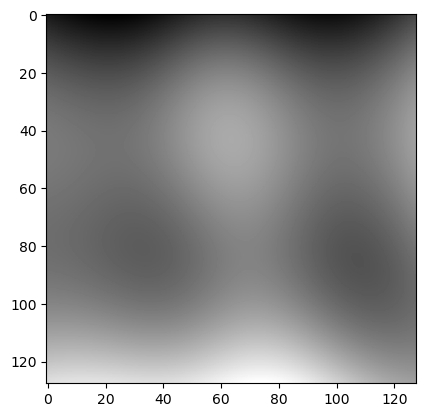

In [173]:
plt.imshow(pred[0].reshape(128, 128), cmap='gray')
plt.savefig('partb_circle.png', dpi=160)

In [147]:
a = torch.matmul(Htensor, pred[0].type(torch.cfloat))

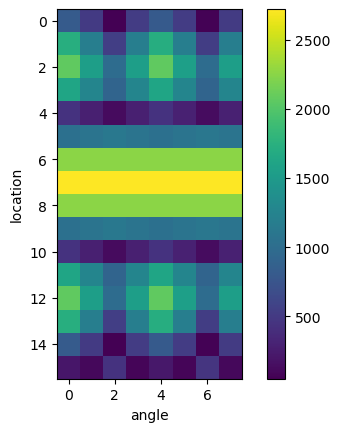

In [148]:
plt.imshow(a.abs().reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.colorbar()
plt.savefig('pred_abs_helm.png', dpi=160)

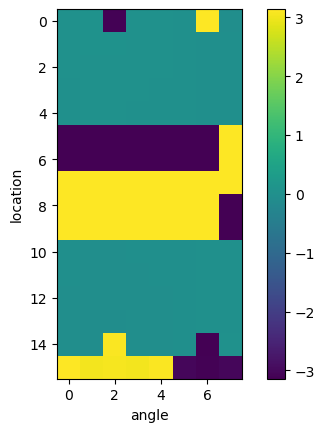

In [149]:
plt.imshow(a.angle().reshape(8, 16).T)
plt.xlabel('angle')
plt.ylabel('location')
plt.colorbar()
plt.savefig('pred_phase_helm.png', dpi=160)

In [112]:
mse = nn.MSELoss()
mse(a, torch.tensor(g))

RuntimeError: "mse_cpu" not implemented for 'ComplexFloat'